In [308]:
import numpy as np

### Introduction
Model of electric engine. 
1000 - 10000 RPMs.

Differential equation describing the system.

$$J\frac{d\omega}{dt} = M_e - M_0 - M_{LOAD}$$
where:
- $M_e$: electromagnetic moment
- $M_0$: braking moment
- $M_{LOAD}$: load moment
- $I$: moment of inertia

Transformation to differential form using the Eulerian method.
$$I\frac{d\omega(t+\Delta t) - \omega (t)}{\Delta t} = M_e(t)-M_0-M_{LOAD}(t)$$
$$\omega (t+\Delta t) = \omega(t) + \frac{\Delta t}{I}(M_e(t)- M_0-M_{LOAD}(t))$$

What about $M_e(t)$?
$$U_{PI}(t) = Kp \cdot e(t) + Ki \sum^t_{k=0}e(k)\Delta t$$
$$M_e(t) = U_{PI} * const$$
$$e(t) = \omega_{ref} - \omega(t)$$

### Defined Parameters

In [309]:
# Parameters of simulation
referencedRevolutionsPerMinute = 3000

# Simulation time parameters
timeOfSimulation = 1000
timeOfSample = 0.1

# Parameters of crankshaft
brakingMoment = 0.2
loadMoment = 0.5
momentOfInertia = 1.2
constantOfElectromagneticMoment = 0.1 #! dostosowac

# Parameters of PI regulator
Kp = 0.5
Ki = 0.1

# Constraints
Umax = 24
Umin = 0
maximumRevolutionsPerMinute = referencedRevolutionsPerMinute * 1.5 #! Check
maximumElectromagneticMoment = maximumRevolutionsPerMinute / 1500 #! Check

# Lists of measured values
# TODO: Think about initalizing first elements here in list
timeOfSimulationList = [0.0]
loadMomentList = [0.0] 
electromagneticMomentList = [0.0]
adjustmentErrors = [referencedRevolutionsPerMinute]
voltagesList = [0.0]
revolutionsList = [1000]

### Calculations

In [310]:
def calculateNumberOfIterations(timeOfSimulation: int, timeOfSample: float) -> int:
    """ This function calculates number of iterations for simulation of process

        @Parameters:
        - timeOfSimulation (int): total time of simulation in seconds
        - timeOfSample (float): time at which we repeat the measurement in seconds

        @Return:
        - int: number of iterations
    """
    return int(timeOfSimulation / timeOfSample) + 1

In [311]:
def calculateAdjustmentError(referencedRevolutionsPerMinute: float, currentRevolutionsPerMinute: float) -> float:
    # TODO Floats or Integers???
    """ This function calculates adjustment error which is difference between referenced value and current one

        @Parameters:
        - referencedRevolutionsPerMinute (float): set value to be obtained by regulator
        - currentRevolutionsPerMinute (float): current value

        @Return:
        - float: error
    """
    return referencedRevolutionsPerMinute - currentRevolutionsPerMinute

In [312]:
def calculateVoltageOfRegulator(errorList : list[float], iteration: int) -> float:
    """ This funtion calculates current voltage of regulator

        @Parameters:
        - errorList (list[float]): list of errors at the moment and before
        - iteration (int): information about current simulation iteration

        @Return
        - float: current voltage of regulator
    """
    return Kp * errorList[iteration] + Ki * sum(errorList) * timeOfSample

In [313]:
def calculateElectromagneticMoment(constant : float, currentVoltage : float) -> float:
    """ This function calculates current electromagnetic moment based on voltage of regulator

        @Parameters:
        - constant (float): used to scale moment 
        - currentVoltageOfRegulator (float): voltage of regulator at the moment

        @Return
        - float: current electromagnetic moment
    """
    return constant * currentVoltage

In [314]:
def calculateNormalizedVoltage(voltgeOfRegulator : float) -> float:
    """ This function calculates normalized voltage based on predefined constraints <0;24> [V]

    @Parameters:
    - voltageOfRegulator (float): current voltage of regulator

    @Returns:
    - float: normalized voltage used to create electromagnetic moment
    """
    return max(Umin, min(Umax, voltgeOfRegulator))

In [315]:
def calculateRevoltions(revolutionsList, electromagneticMomentList):
    acceleration = (
        electromagneticMomentList[-1] - loadMoment - brakingMoment) / momentOfInertia
    return revolutionsList[-1] + timeOfSample * acceleration

### Simulation

In [316]:
for i in range(calculateNumberOfIterations(timeOfSimulation, timeOfSample)):
    # Update simulation time
    timeOfSimulationList.append(timeOfSimulationList[-1] + timeOfSample)

    # Calculate adjustment error
    adjustmentError = calculateAdjustmentError(
        referencedRevolutionsPerMinute, revolutionsList[-1])
    adjustmentErrors.append(adjustmentError)

    # Calculate normalized voltage
    voltage = calculateNormalizedVoltage(
        calculateVoltageOfRegulator(adjustmentErrors, -1))
    voltagesList.append(voltage)

    # Calculate electromagnetic moment
    electromagneticMoment = calculateElectromagneticMoment(
        constantOfElectromagneticMoment, voltagesList[-1])
    electromagneticMomentList.append(electromagneticMoment)

    # Calculate revolutions and update revolutions list
    revolutions = calculateRevoltions(
        revolutionsList, electromagneticMomentList)
    revolutionsList.append(revolutions)
    #print(f"Step {i}: Referenced RPM = {referencedRevolutionsPerMinute}, Current RPM = {revolutionsList[-1]}, Current Moment = {electromagneticMomentList[-1]}")
    

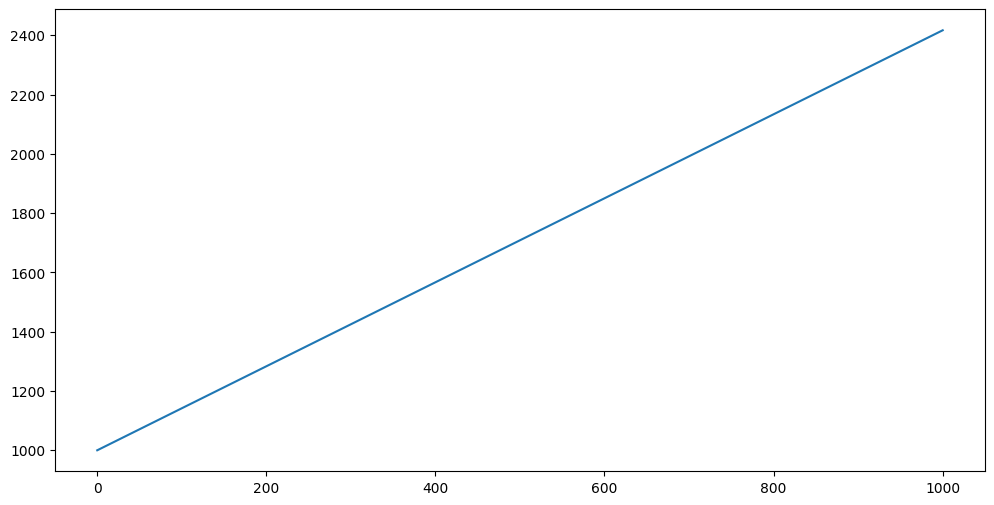

In [317]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(timeOfSimulationList, revolutionsList)